In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, ELU, Flatten, Dense, Activation, Dropout, Lambda, Input, MaxPooling2D, Conv2D
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import time
from sklearn.utils import shuffle
from model import *
import matplotlib.pyplot as plt
%matplotlib inline

Preprocess a sample image

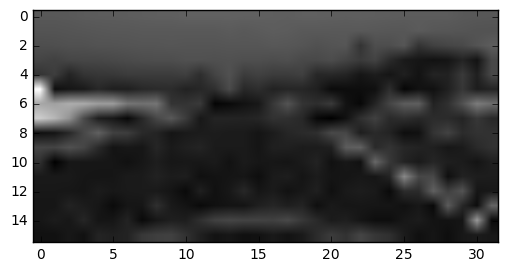

In [62]:
DATASET = "./dataset"

image = os.path.join(DATASET, "exper/2.jpg")
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(cv2.resize(image,(32,16)), cv2.COLOR_RGB2HSV)
image = image[:,:,1]
plt.imshow(image, cmap='gray')

Show weights at flatten layer

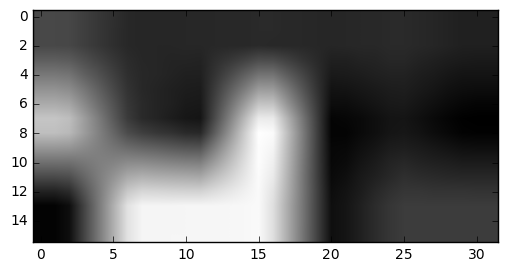

In [64]:
from keras.models import Model

with open("model.json", 'r') as jfile:
    model = model_from_json(jfile.read())
model.load_weights("model.h5")

pred_img = image.reshape(1, 16, 32, 1)
layer_name = 'flatten_1'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(pred_img)

output_img = intermediate_output.reshape(3,7,2)
output_img = output_img[:,:,1]
output_img = cv2.normalize(output_img, 0, 255, cv2.NORM_MINMAX).astype('uint8')
output_img = cv2.resize(output_img, (32,16))
plt.imshow(output_img, cmap='gray')

In [65]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 16, 32, 1)     0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 14, 30, 2)     20          lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 3, 7, 2)       0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 3, 7, 2)       0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

Generate video showing input and output from a selected layer

In [57]:
import os
files = os.listdir("dataset/feed")
sorted(files)
frames = []

# smallest

# org_input_cols = 100
# org_input_rows = 52
# bottom_cell_cols = 32
# bottom_cell_rows = 16
# model_input_cols = 32
# model_input_rows = 16
# layer_cols = 7
# layer_rows = 3

# small

# org_input_cols = 196
# org_input_rows = 100
# bottom_cell_cols = 64
# bottom_cell_rows = 32
# model_input_cols = 32
# model_input_rows = 16
# layer_cols = 7
# layer_rows = 3

# medium

org_input_cols = 244
org_input_rows = 124
bottom_cell_cols = 80
bottom_cell_rows = 48
model_input_cols = 32
model_input_rows = 16
layer_cols = 7
layer_rows = 3

separator = np.zeros((1,1,3), np.uint8)
v_separ = cv2.resize(separator, (2, bottom_cell_rows))
h_separ = cv2.resize(separator, (org_input_cols, 2))

for i in range(len(files)):
    path = os.path.join("dataset/feed", files[i])
    image = cv2.imread(path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # preprocess
        resized_img = cv2.resize(image,(model_input_cols, model_input_rows)) 
        preproc_img = (cv2.cvtColor(resized_img, cv2.COLOR_BGR2HSV))[:,:,1]
        preproc_img = preproc_img.reshape(1, model_input_rows, model_input_cols, 1)
        
        # through the model
        intermediate_output = intermediate_layer_model.predict(preproc_img)        
        output_img = intermediate_output.reshape(layer_rows, layer_cols,2)[:,:,1]
        
        # denormalize output layer
        output_img = cv2.normalize(output_img, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        
        # prepare sub images - some resizing and rgb colorspace
        output_img = cv2.resize(output_img, (bottom_cell_cols, bottom_cell_rows))                
        output_img = cv2.cvtColor(output_img, cv2.COLOR_GRAY2RGB)
        resized_img_1 = cv2.resize(image,(bottom_cell_cols, bottom_cell_rows))
        preproc_img_2 = (cv2.cvtColor(resized_img_1, cv2.COLOR_BGR2HSV))[:,:,1]
        preproc_img_2 = cv2.cvtColor(preproc_img_2, cv2.COLOR_GRAY2RGB)
        
        # compose frame 
        row_1_image = cv2.resize(image, (org_input_cols, org_input_rows), interpolation=cv2.INTER_AREA)        
        row_2_image = np.hstack((resized_img_1, v_separ, preproc_img_2, v_separ, output_img))
        new_frame = np.vstack((row_1_image, h_separ, row_2_image))
        
        frames.append(new_frame)
    
from moviepy.editor import *

new_clip = ImageSequenceClip(frames, fps=10)
new_clip.write_gif("model_visualization.gif") 
#new_clip.write_videofile("layers_visualization.mp4")


[MoviePy] Building file model_visualization.gif with imageio


100%|██████████| 59/59 [00:00<00:00, 290.85it/s]
